# Soccer Match Predictor 

Our goal is to predict the winner of a soccer match using the Poisson distribution. I'm a fan of the Serie A, so we'll use data from the first 37 matches of the 2017/18 season to try and predict the outcome of the final matchday. 

## Import Data

In [3]:
import pandas as pd
seriea_df = pd.read_csv('seriea1718.csv')
seriea_df.head()

,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,...,BbAv<2.5,BbAH,BbAHh,BbMxAHH,BbAvAHH,BbMxAHA,BbAvAHA,PSCH,PSCD,PSCA
0,I1,19/08/17,Juventus,Cagliari,3,0,H,2,0,H,...,2.41,16,-2.00,1.83,1.80,2.13,2.07,1.13,9.74,27.70
1,I1,19/08/17,Verona,Napoli,1,3,A,0,2,A,...,2.29,16,1.25,1.98,1.95,1.97,1.92,8.37,5.21,1.41
2,I1,20/08/17,Atalanta,Roma,0,1,A,0,1,A,...,2.06,16,0.25,1.91,1.88,2.04,1.99,2.99,3.44,2.53
3,I1,20/08/17,Bologna,Torino,1,1,D,1,1,D,...,1.75,16,0.25,1.90,1.87,2.06,2.00,3.35,3.47,2.31
4,I1,20/08/17,Crotone,Milan,0,3,A,0,3,A,...,2.06,17,1.00,1.89,1.85,2.08,2.02,7.42,4.37,1.52


The only columns that we're interested in are home team, away team, home team goals, and away team goals.

In [4]:
seriea_df = seriea_df[['HomeTeam', 'AwayTeam', 'FTHG','FTAG']]
seriea_df = seriea_df.rename(index = str, columns = {'HomeTeam':'Home', 'AwayTeam': 'Away', 'FTHG': 'HomeGoals', 'FTAG': 'AwayGoals'})
seriea_df.head()

,Home,Away,HomeGoals,AwayGoals
0,Juventus,Cagliari,3,0
1,Verona,Napoli,1,3
2,Atalanta,Roma,0,1
3,Bologna,Torino,1,1
4,Crotone,Milan,0,3


In [5]:
print('Average number of goals per game for the home team: ', seriea_df['HomeGoals'].mean())
print('Average number of goals per game for the away team: ', seriea_df['AwayGoals'].mean())

Average number of goals per game for the home team:  1.4552631578947368
Average number of goals per game for the away team:  1.2210526315789474


We can see that the home team has a goal scoring over the away team. 

## Why Poisson?

In [6]:
import math
import numpy as np
import matplotlib.pyplot as plt

The Poisson distribution is defined as $P(k)=\frac{\lambda ^{k}}{k!}e^{-k}$, where $\lambda$ is the average number of goals per game by the given team and $k$ is the number of goals in a match. 


In [8]:
def poisson(k,l):
    return (l**k*math.exp(-l))/math.factorial(k)

A key assumption we are making is that goals scored is independent with time, i.e., the number of goals scored will not be more or less likely to happen based on the number of goals earlier. 

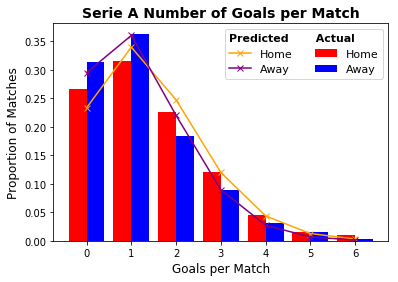

In [9]:
# Construct Poisson for each mean goals value
poissonPred = np.column_stack([[poisson(i, seriea_df.mean()[j]) for i in range(7)] for j in range(2)])

# plot histogram of actual goals
plt.hist(seriea_df[['HomeGoals', 'AwayGoals']].values, range(8), label=['Home', 'Away'],density=True, color=["red", "blue"])

# add graphs of the Poisson distribution values
plt.plot([i-0.5 for i in range(1,8)], poissonPred[:,0], linestyle='-', marker='x',label="Home", color = 'orange')
plt.plot([i-0.5 for i in range(1,8)], poissonPred[:,1], linestyle='-', marker='x',label="Away", color = 'purple')

leg=plt.legend(loc='upper right', fontsize=11, ncol=2)
leg.set_title("Predicted       Actual      ", prop = {'size':'11', 'weight':'bold'})

plt.xticks([i-0.5 for i in range(1,8)],[i for i in range(8)])
plt.xlabel("Goals per Match",size=12)
plt.ylabel("Proportion of Matches",size=12)
plt.title("Serie A Number of Goals per Match",size=14,fontweight='bold')
plt.show()

We can see that the Poisson distribution is pretty acurate at predicting goals per match. 

### Model

In [10]:
# Remove the last week of matches
seriea_df = seriea_df[:-10]

In [11]:
# Calculating a team's attacking strength: (Team's mean goal/ Total mean goals for league)   
def homeAttStrength( str):
    teamHome = seriea_df[seriea_df['Home'].str.contains(str)] 
    return teamHome['HomeGoals'].mean()/seriea_df['HomeGoals'].mean()

def awayAttStrength( str):
    teamAway = seriea_df[seriea_df['Away'].str.contains(str)]  
    return teamAway['AwayGoals'].mean()/seriea_df['AwayGoals'].mean()

# Calculating a team's defensive strength: (Team's mean goal/ Total mean goals for league)   
def homeDefStrength( str):
    teamHome = seriea_df[seriea_df['Home'].str.contains(str)]  
    return teamHome['AwayGoals'].mean()/seriea_df['AwayGoals'].mean()

def awayDefStrength( str):
    teamAway = seriea_df[seriea_df['Away'].str.contains(str)]  
    return teamAway['HomeGoals'].mean()/seriea_df['HomeGoals'].mean()

In [16]:
# Create predictor
# t1 is the home team
def matchOutcomes(t1,t2,max_goals):
    t1goals = homeAttStrength(t1)*awayDefStrength(t2)*seriea_df['HomeGoals'].mean() #Computes home attack strength
    t2goals = awayAttStrength(t2)*awayDefStrength(t1)*seriea_df['AwayGoals'].mean() #Computes away attack strength
    team_pred1 = []
    team_pred2 = []
    for i in range(max_goals):
        team_pred1.append(poisson(i,t1goals))
    for j in range(max_goals):
        team_pred2.append(poisson(j,t2goals))    
    return(np.outer(np.array(team_pred1), np.array(team_pred2)))

def predictMatch(t1,t2):
    win =  np.sum(np.tril(matchOutcomes(t1, t2, max_goals=6), -1))
    draw = np.sum(np.diag(matchOutcomes(t1, t2, max_goals=6)))
    lose = np.sum(np.triu(matchOutcomes(t1, t2, max_goals=6), 1))
    
    if (win > draw) & (win > lose):
        print(t1 , 'Wins with probability' , win, ' Probability of a draw: ',draw)
    elif ( draw > win ) & (draw > lose):
        print(t1, t2, 'Draw with probability', draw)
    elif (lose > win ) & (lose > draw):
        print(t2, 'Wins with probability' , lose, ' Probability of a draw: ',draw) 

The MatchOutcomes will spit out a 6x6 array of the probabilites for each final score. For example, consider the match: Sassuolo vs. As Roma, where Roma is the home team:

In [17]:
matchOutcomes('Sassuolo', 'Roma', 6)

array([[9.24462343e-02, 2.00590695e-01, 2.17621774e-01, 1.57399247e-01,
        8.53815856e-02, 3.70523510e-02],
       [1.95356269e-02, 4.23885841e-02, 4.59875711e-02, 3.32614192e-02,
        1.80427338e-02, 7.82985818e-03],
       [2.06412257e-03, 4.47875226e-03, 4.85901906e-03, 3.51438152e-03,
        1.90638439e-03, 8.27298099e-04],
       [1.45395965e-04, 3.15481511e-04, 3.42267352e-04, 2.47551623e-04,
        1.34284951e-04, 5.82745459e-05],
       [7.68122505e-06, 1.66667932e-05, 1.80818811e-05, 1.30780777e-05,
        7.09423352e-06, 3.07862671e-06],
       [3.24637445e-07, 7.04401334e-07, 7.64208268e-07, 5.52728725e-07,
        2.99828976e-07, 1.30114338e-07]])

The probability that the match finishes 0-1 in Roma's favor is about 20% (Actual outcome). The probability of a 1-1 draw is about 4%. 


To predict the probability of a home team win, we sum the elements below the diagonal. The trace will give the probability of a draw, and the sum of the elements above the diagonal will give the probability of an away win.

### Final week predictions

In [18]:
predictMatch('Juventus','Verona')
predictMatch('Genoa','Torino')
predictMatch('Napoli','Crotone')
predictMatch('Chievo','Benevento')
predictMatch('Cagliari','Atalanta')
predictMatch('Milan','Fiorentina')
predictMatch('Spal','Sampdoria')
predictMatch('Udinese','Bologna')
predictMatch('Lazio','Inter')
predictMatch('Sassuolo','Roma')

Juventus Wins with probability 0.7470023785872002  Probability of a draw:  0.055002535507762136
Genoa Wins with probability 0.4865595615176665  Probability of a draw:  0.29294145102693997
Napoli Wins with probability 0.7912991544042732  Probability of a draw:  0.06085699717809239
Chievo Wins with probability 0.648659058207451  Probability of a draw:  0.20838758684512587
Atalanta Wins with probability 0.5979340084913949  Probability of a draw:  0.2370398068273471
Fiorentina Wins with probability 0.4965123763870239  Probability of a draw:  0.2782393890984025
Spal Wins with probability 0.4478256049302647  Probability of a draw:  0.2561942319095091
Udinese Wins with probability 0.411524267029562  Probability of a draw:  0.28666937265574044
Inter Wins with probability 0.4526345902456903  Probability of a draw:  0.2600505170321492
Roma Wins with probability 0.8096109364267624  Probability of a draw:  0.13994861346028098


Actual winners: <br>
Juventus <br>
Torino <br>
Napoli   <br>
Chievo <br>
Cagliari <br>
Ac Milan <br>
Spal <br>
Udinese <br> 
Inter <br> 
Roma

The model predicted the correct result for 7 of the 10 matches.


## Improvements

We built a relatively simple model using important features like home field advantage, home attack strength, etc., to predict the outcome of a soccer match. This model doesn't really put much weight on the recent form of a team. A more complicated model can use data such as form of individual players, weather conditions, and head to head history. <br>
<br>
In summary, this is a great starting point for building a more sophisticated model.